# Load data

In [9]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [10]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_set[0][0].shape

torch.Size([3, 32, 32])

# Train model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [13]:
# Select device
device = torch.device('cuda')

In [14]:
torch.cuda.is_available()

True

In [15]:
# Check for model
if os.path.isfile('cifar resnet.pt'):
    # Load saved model
    print('Loading saved model')
    model = ResNet18(num_classes=10)
    model.load_state_dict(torch.load('cifar resnet.pt'))
    model.to(device)

else:
    # Create model
    model = ResNet18(num_classes=10).to(device)

    # Training parameters
    lr = 1e-3
    mbsize = 256  # 16
    max_nepochs = 250
    loss_fn = nn.CrossEntropyLoss()
    lookback = 10
    verbose = True

    # Validation function
    val_loader = DataLoader(val_set, batch_size=mbsize, shuffle=False, num_workers=4)

    def validate(model):
        n = 0
        mean_loss = 0
        mean_acc = 0

        for x, y in val_loader:
            # Move to GPU.
            n += len(x)
            x = x.to(device)
            y = y.to(device)

            # Get predictions.
            pred = model(x)

            # Update loss.
            loss = loss_fn(pred, y).item()
            mean_loss += len(x) * (loss - mean_loss) / n

            # Update accuracy.
            acc = (torch.argmax(pred, dim=1) == y).float().mean().item()
            mean_acc += len(x) * (acc - mean_acc) / n

        return mean_loss, mean_acc

    # Data loader
    train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True,
                              drop_last=True, num_workers=4)

    # Setup
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=lookback // 2, min_lr=1e-5,
        mode='max', verbose=verbose)
    loss_list = []
    acc_list = []
    min_criterion = np.inf
    min_epoch = 0

    # Train
    for epoch in range(max_nepochs):
        for x, y in tqdm(train_loader, desc='Training loop', leave=True):
            # Move to device.
            x = x.to(device=device)
            y = y.to(device=device)

            # Take gradient step.
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # Check progress.
        with torch.no_grad():
            # Calculate validation loss.
            model.eval()
            val_loss, val_acc = validate(model)
            model.train()
            if verbose:
                print('----- Epoch = {} -----'.format(epoch + 1))
                print('Val loss = {:.4f}'.format(val_loss))
                print('Val acc = {:.4f}'.format(val_acc))
            loss_list.append(val_loss)
            acc_list.append(val_acc)
            scheduler.step(val_acc)

            # Check convergence criterion.
            val_criterion = - val_acc
            if val_criterion < min_criterion:
                min_criterion = val_criterion
                min_epoch = epoch
                best_model = deepcopy(model)
                print('')
                print('New best epoch, acc = {:.4f}'.format(val_acc))
                print('')
            elif (epoch - min_epoch) == lookback:
                if verbose:
                    print('Stopping early')
                break

    # Keep best model
    model = best_model
    
    # Save model
    model.cpu()
    torch.save(model.state_dict(), 'cifar resnet.pt')
    model.to(device)

Loading saved model


# Train surrogate

In [16]:
sys.path.insert(1, '/home/sidtandon/Sid/GitRepo/FastShapExt')

In [17]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [18]:
import time

start = time.time()

# Check for model
if os.path.isfile('cifar surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('cifar surrogate.pt').to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

else:
    # Create model
    surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)
    
    '''
    # Copy resent weights from original model
    for name, param in model.state_dict().items():
        _name = "1." + name 
        #print(name,param.shape)
        surr_state_dict = surr.state_dict()
        if _name != "1.conv1.weight":
            surr_state_dict[_name].copy_(param.data)

    for name, param in surr.named_parameters():
        if param.requires_grad and '1.conv1.weight' != name:
            param.requires_grad = False
    '''
    # Set up surrogate object
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)
    
    # Set up datasets
    train_surr = DatasetInputOnly(train_set)
    val_surr = DatasetInputOnly(val_set)
    original_model = nn.Sequential(model, nn.Softmax(dim=1))

    # Train
    surrogate.train_original_model_bkup(
        train_surr,
        val_surr,
        original_model,
        batch_size=256,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save surrogate
    surr.cpu()
    torch.save(surr.state_dict(), 'cifar surrogate.pt')
    surr.to(device)

end  = time.time() - start
print(f"Time Taken: {end}")

Training epoch: 100%|██████████| 196/196 [00:54<00:00,  3.63it/s]


----- Epoch = 1 -----
Val loss = 1.5722

New best epoch, loss = 1.5722



Training epoch: 100%|██████████| 196/196 [00:55<00:00,  3.54it/s]


----- Epoch = 2 -----
Val loss = 1.4661

New best epoch, loss = 1.4661



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 3 -----
Val loss = 1.3494

New best epoch, loss = 1.3494



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 4 -----
Val loss = 1.1871

New best epoch, loss = 1.1871



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 5 -----
Val loss = 1.1152

New best epoch, loss = 1.1152



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 6 -----
Val loss = 0.9925

New best epoch, loss = 0.9925



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 7 -----
Val loss = 0.9666

New best epoch, loss = 0.9666



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 8 -----
Val loss = 0.9635

New best epoch, loss = 0.9635



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 9 -----
Val loss = 0.8979

New best epoch, loss = 0.8979



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 10 -----
Val loss = 0.7948

New best epoch, loss = 0.7948



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 11 -----
Val loss = 0.7817

New best epoch, loss = 0.7817



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 12 -----
Val loss = 0.7317

New best epoch, loss = 0.7317



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 13 -----
Val loss = 0.7729



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]


----- Epoch = 14 -----
Val loss = 0.7361



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 15 -----
Val loss = 0.7371



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 16 -----
Val loss = 0.7054

New best epoch, loss = 0.7054



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 17 -----
Val loss = 0.6616

New best epoch, loss = 0.6616



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


----- Epoch = 18 -----
Val loss = 0.7548



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 19 -----
Val loss = 0.6793



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 20 -----
Val loss = 0.6487

New best epoch, loss = 0.6487



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 21 -----
Val loss = 0.6852



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 22 -----
Val loss = 0.6162

New best epoch, loss = 0.6162



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 23 -----
Val loss = 0.6695



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 24 -----
Val loss = 0.6148

New best epoch, loss = 0.6148



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


----- Epoch = 25 -----
Val loss = 0.6665



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 26 -----
Val loss = 0.6393



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 27 -----
Val loss = 0.5782

New best epoch, loss = 0.5782



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 28 -----
Val loss = 0.6217



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 29 -----
Val loss = 0.6234



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 30 -----
Val loss = 0.5907



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


----- Epoch = 31 -----
Val loss = 0.6025



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 32 -----
Val loss = 0.6156



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s]


----- Epoch = 33 -----
Val loss = 0.5699

New best epoch, loss = 0.5699



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 34 -----
Val loss = 0.5952



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 35 -----
Val loss = 0.6287



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 36 -----
Val loss = 0.5974



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 37 -----
Val loss = 0.6129



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 38 -----
Val loss = 0.5902



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 39 -----
Val loss = 0.5992

Epoch 00039: reducing learning rate of group 0 to 5.0000e-04.


Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 40 -----
Val loss = 0.5468

New best epoch, loss = 0.5468



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 41 -----
Val loss = 0.5591



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 42 -----
Val loss = 0.5708



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


----- Epoch = 43 -----
Val loss = 0.5594



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 44 -----
Val loss = 0.5628



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 45 -----
Val loss = 0.5825



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 46 -----
Val loss = 0.5634

Epoch 00046: reducing learning rate of group 0 to 2.5000e-04.


Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]


----- Epoch = 47 -----
Val loss = 0.5517



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]


----- Epoch = 48 -----
Val loss = 0.5475



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 49 -----
Val loss = 0.5671



Training epoch: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


----- Epoch = 50 -----
Val loss = 0.5558

Stopping early
Time Taken: 7556.469554901123


In [17]:
surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)

surr.load_state_dict(torch.load('cifar surrogate.pt'))
surr.to(device)

# Set up surrogate object
surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

# Set up datasets
train_surr = DatasetInputOnly(train_set)
val_surr = DatasetInputOnly(val_set)
original_model = nn.Sequential(model, nn.Softmax(dim=1))

# Train
surrogate.train_original_model(
    train_surr,
    val_surr,
    original_model,
    batch_size=256,
    max_epochs=100,
    loss_fn=KLDivLoss(),
    lookback=10,
    bar=True,
    verbose=True)

# Save surrogate
surr.cpu()
torch.save(surr.state_dict(), 'cifar surrogate.pt')
surr.to(device)

Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.29it/s]


----- Epoch = 1 -----
Val loss = 0.7462

New best epoch, loss = 0.7462



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


----- Epoch = 2 -----
Val loss = 0.6835

New best epoch, loss = 0.6835



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


----- Epoch = 3 -----
Val loss = 0.6605

New best epoch, loss = 0.6605



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


----- Epoch = 4 -----
Val loss = 0.6194

New best epoch, loss = 0.6194



Training epoch: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]


----- Epoch = 5 -----
Val loss = 0.6264



Training epoch: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]


----- Epoch = 6 -----
Val loss = 0.6103

New best epoch, loss = 0.6103



Training epoch: 100%|██████████| 196/196 [01:05<00:00,  2.98it/s]


----- Epoch = 7 -----
Val loss = 0.5965

New best epoch, loss = 0.5965



Training epoch: 100%|██████████| 196/196 [01:01<00:00,  3.18it/s]


----- Epoch = 8 -----
Val loss = 0.5996



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.21it/s]


----- Epoch = 9 -----
Val loss = 0.5813

New best epoch, loss = 0.5813



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


----- Epoch = 10 -----
Val loss = 0.5864



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


----- Epoch = 11 -----
Val loss = 0.5975



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]


----- Epoch = 12 -----
Val loss = 0.5751

New best epoch, loss = 0.5751



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]


----- Epoch = 13 -----
Val loss = 0.6011



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]


----- Epoch = 14 -----
Val loss = 0.5979



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]


----- Epoch = 15 -----
Val loss = 0.5685

New best epoch, loss = 0.5685



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 16 -----
Val loss = 0.5687



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 17 -----
Val loss = 0.5665

New best epoch, loss = 0.5665



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 18 -----
Val loss = 0.5722



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 19 -----
Val loss = 0.5621

New best epoch, loss = 0.5621



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 20 -----
Val loss = 0.5747



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 21 -----
Val loss = 0.5592

New best epoch, loss = 0.5592



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 22 -----
Val loss = 0.5393

New best epoch, loss = 0.5393



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.27it/s]


----- Epoch = 23 -----
Val loss = 0.6007



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 24 -----
Val loss = 0.5724



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 25 -----
Val loss = 0.5865



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 26 -----
Val loss = 0.5564



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 27 -----
Val loss = 0.5122

New best epoch, loss = 0.5122



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 28 -----
Val loss = 0.5781



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 29 -----
Val loss = 0.5592



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 30 -----
Val loss = 0.5455



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 31 -----
Val loss = 0.5248



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 32 -----
Val loss = 0.5347



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 33 -----
Val loss = 0.5524

Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.


Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 34 -----
Val loss = 0.5100

New best epoch, loss = 0.5100



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 35 -----
Val loss = 0.5061

New best epoch, loss = 0.5061



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 36 -----
Val loss = 0.5078



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 37 -----
Val loss = 0.5204



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 38 -----
Val loss = 0.5008

New best epoch, loss = 0.5008



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 39 -----
Val loss = 0.5197



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 40 -----
Val loss = 0.5174



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.28it/s]


----- Epoch = 41 -----
Val loss = 0.5219



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 42 -----
Val loss = 0.5321



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 43 -----
Val loss = 0.5318



Training epoch: 100%|██████████| 196/196 [01:00<00:00,  3.27it/s]


----- Epoch = 44 -----
Val loss = 0.5332

Epoch 00044: reducing learning rate of group 0 to 2.5000e-04.


Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 45 -----
Val loss = 0.5118



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 46 -----
Val loss = 0.5039



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 47 -----
Val loss = 0.5257



Training epoch: 100%|██████████| 196/196 [00:59<00:00,  3.27it/s]


----- Epoch = 48 -----
Val loss = 0.5240

Stopping early


Sequential(
  (0): MaskLayer2d()
  (1): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): ModuleList(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size

In [16]:
# @title Read data

# Train FastSHAP

In [13]:
from unet import UNet
from fastshap import FastSHAP

In [14]:
# Check for model
start = time.time()

if os.path.isfile('cifar explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'cifar explainer.pt')
    explainer.to(device)

end = time.time() - start
print(f"Time taken: {end}")

Loading saved explainer model
Time taken: 0.06327939033508301


# Visualize results

In [26]:
import matplotlib.pyplot as plt

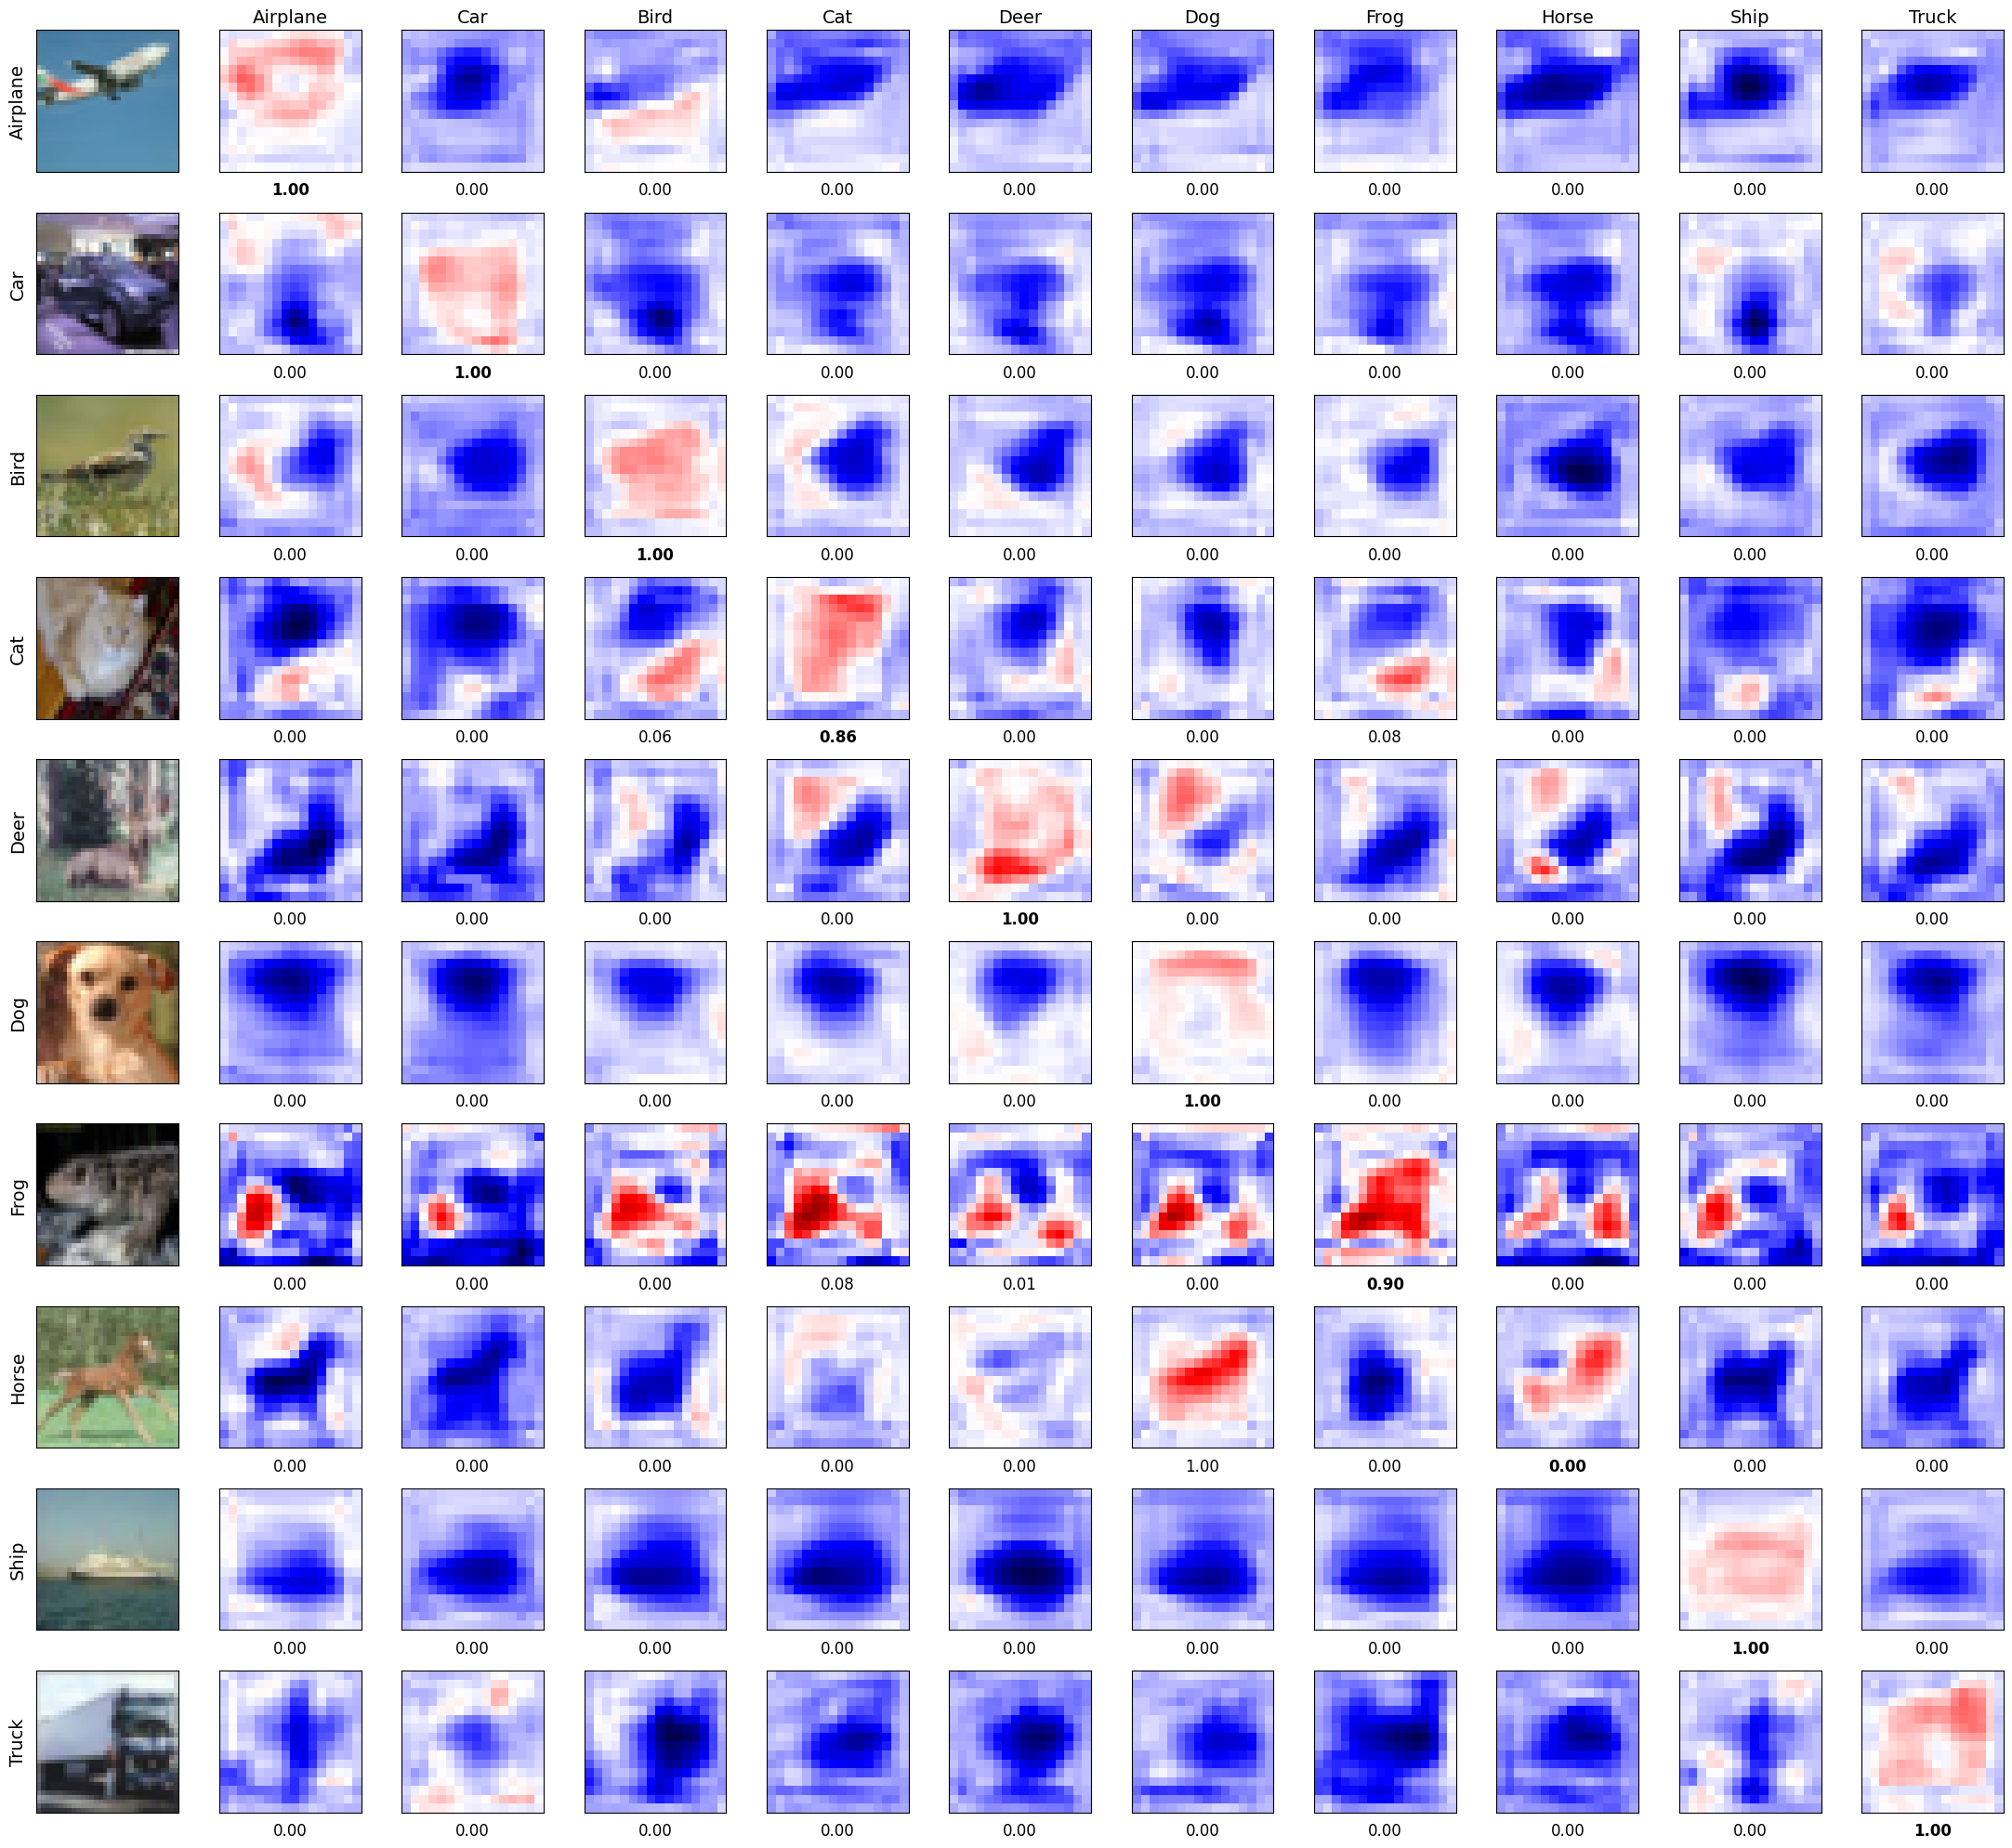

In [27]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()